In [1]:
import numpy as np
import json
import random
from collections import defaultdict

import torch
from torch.utils.data import DataLoader
from torch import linalg as LA

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import *
from utilitiesDL import *
torch.set_num_threads(1)

## Parameter Configuration

In [3]:
jsonFileName = './inputJson/genData_TAR.json'

f = open(jsonFileName)
inputJson = json.load(f)
dataPathBase = inputJson['dataPathBase']
dataType = inputJson['dataType']
dSamp = inputJson['dSamp']
padLen = inputJson['padLen']
dataWinTarget = inputJson['dataWin']
surro = inputJson['surro']
attackScheme = 'GAIL'
dataWin = False
f.close()

cudaID = 4
if cudaID >= 0:
    device = torch.device("cuda:"+str(cudaID))
    cudaAvbl = True
else:
    device = torch.device("cpu")
    cudaAvbl = False


print("Datatype:", dataType)
if dataType == 'JAR':
    fs = 320
    nSubC = 30
    nRX = 3
    dSampFactor = 1
    activities = ['sitstill', 'falldown', 'liedown', 'standstill', 'walk', 'turn', 'stand', 'sit']

elif dataType == 'TAR':
    fs = 500 # 1 kHz
    nSubC = 30
    nRX = 3
    activities = ['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']
    # activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']
    variableLen = not(dataWinTarget)
    # if dataWinTarget:
    seqLen = 1000
    slideLen = 200

if surro:
    dSampSurro = dSamp
else:
    dSampTarget = dSamp

dataPath = dataPathBase + "HAR_" + dataType + "/"
if dataType == 'JAR':
    dataPath = dataPath + "dSamp_" + str(dSamp) + "/"
elif dataType == 'TAR':
    if dataWin:
        if attackScheme == "GAIL":
            dataPath = dataPath + "win_dSamp_" + str(dSamp) + "_" + attackScheme + "/"
        else:
            dataPath = dataPath + "win_dSamp_" + str(dSamp) + "_pad_" + str(padLen) + "/"
    else:
        dataPath = dataPath + "noWin_dSamp_" + str(dSamp) + "_pad_" + str(padLen) + "/"
print('dataPath:', dataPath)

Datatype: TAR
dataPath: /project/iarpa/wifiHAR/HAR_TAR/noWin_dSamp_10_pad_9/


## Load data

In [4]:
noiseAmpRatio = .5

dataDict = {file:[] for file in activities}
for activity in activities:
    dataDict[activity] = defaultdict(list)

if attackScheme == "GAIL":
    fileName_prefix = "input_TAR_BiLSTM_H_200_dS_10_"
    fileName_prefix_attack = "GAIL_TAR_BiLSTM_H_200_dS_10_"
elif attackScheme == "BC":
    fileName_prefix = "input_TAR_BiLSTM_H_200_dS_10_"
    fileName_prefix_attack = "BC_TAR_BiLSTM_H_200_dS_10_"
else:
    fileName_prefix = "xx_"

lenList = []
if dataType == "JAR":
    for actIdx, activity in enumerate(activities):
        xxLoadNP = np.load(dataPath + "xx_" + activity + ".npy", allow_pickle=True)
        for dataInd, data in enumerate(xxLoadNP):
            dataDict[activity]['input'].append(data)
            dataDict[activity]['label'].append(np.argwhere(np.array(activities) == activity)[0][0])

        print(activity, len(dataDict[activity]['input']))

elif dataType == "TAR":
    for actIdx, activity in enumerate(activities):
        longestLen = 0
        shortestLen = 10000

        xxLoadNP = np.load(dataPath + "xx_" + activity + ".npy", allow_pickle=True)
        if attackScheme == "GAIL" or attackScheme == "BC":
            GAILLoadNP = np.load(dataPath + fileName_prefix_attack + activity + ".npy", allow_pickle=True)
            for dataInd, (data, dataGAIL) in enumerate(zip(xxLoadNP, GAILLoadNP)):
                if data.shape[0] > longestLen:
                    longestLen = data.shape[0]
                if data.shape[0] < shortestLen:
                    shortestLen = data.shape[0]
                # print(LA.norm(data), LA.norm(dataGAIL*10))
                dataDict[activity]['input'].append((data + dataGAIL * noiseAmpRatio * 10))
        else:
            for dataInd, data in enumerate(xxLoadNP):
                # print(data.shape)
                if data.shape[0] > longestLen:
                    longestLen = data.shape[0]
                if data.shape[0] < shortestLen:
                    shortestLen = data.shape[0]
                dataDict[activity]['input'].append(data)
        lenList.append(LA.norm(torch.Tensor(data)))
        dataDict[activity]['label'] = actIdx*torch.ones(len(dataDict[activity]['input']), dtype=int, device=device)

        print(activity, len(dataDict[activity]['input']), len(dataDict[activity]['label']), shortestLen, longestLen)

NameError: name 'GAILLoadNP' is not defined

## Create train/test torch dataset

In [4]:
if dataWin:
    batchSize = 200
else:
    batchSize = 1
trData = list()
tsData = list()

random.seed(1)
for actIndex, activity in enumerate(activities):
    dataset = CSIDataset(dataDict[activity],\
                        device,\
                        normalize=True,\
                        nSubC=nSubC,\
                        nRX=nRX,\
                        padLen=padLen)
    # nTrData = np.floor(len(dataset)*0.01).astype(int)
    # nTsData = np.floor(len(dataset)).astype(int) - nTrData

    if dataType == "JAR":
        padLen = 0
        if actIndex == 0:
            surroTsList = [512, 1, 2, 514, 4, 6, 7, 8, 519, 520, 523, 524, 13, 525, 15, 527, 17, 18, 530, 20, 21,\
                        22, 533, 534, 535, 538, 28, 541, 30, 31, 32, 33, 547, 36, 37, 38, 39, 40, 548, 42, 549,\
                        551, 553, 554, 47, 48, 49, 556, 51, 52, 53, 559, 562, 56, 57, 563, 564, 60, 61, 62, 63,\
                        567, 65, 570, 67, 68, 69, 575, 71, 72, 583, 584, 75, 585, 77, 588, 79, 80, 81, 82, 83, 589,\
                        85, 86, 590, 88, 592, 594, 91, 92, 93, 94, 95, 96, 99, 100, 102, 107, 109, 111, 112, 113, 116,\
                        118, 124, 126, 128, 130, 133, 135, 137, 138, 140, 141, 146, 147, 150, 153, 154, 155, 156, 161,\
                        163, 166, 167, 172, 173, 177, 178, 181, 182, 186, 187, 188, 190, 198, 199, 202, 203, 207, 208,\
                        211, 212, 213, 214, 218, 220, 221, 223, 225, 226, 229, 230, 234, 235, 238, 239, 240, 241, 247,\
                        252, 254, 255, 256, 257, 258, 259, 261, 262, 267, 270, 273, 274, 276, 277, 278, 279, 281, 282,\
                        285, 287, 289, 291, 292, 293, 296, 297, 299, 301, 302, 303, 304, 309, 571, 315, 317, 572, 321,\
                        322, 331, 336, 337, 339, 341, 344, 345, 347, 348, 350, 351, 353, 355, 356, 358, 360, 363, 369,\
                        371, 373, 374, 375, 376, 377, 378, 379, 381, 388, 392, 394, 395, 398, 403, 404, 406, 407, 409,\
                        410, 411, 412, 414, 415, 591, 420, 421, 422, 423, 424, 426, 427, 431, 434, 435, 436, 437, 438,\
                        439, 440, 441, 447, 449, 451, 453, 454, 455, 599, 458, 459, 460, 461, 462, 463, 464, 465, 466,\
                        467, 470, 471, 472, 473, 474, 475, 477, 478, 479, 481, 482, 485, 487, 488, 490, 491, 494, 496, 500, 501, 502, 503, 504, 505, 506]
            if surro:
                tsDataList = surroTsList
                trDataList = list(set(range(len(dataset))) - set(tsDataList))
            else:
                trDataList = surroTsList
                tsDataList = list(set(range(len(dataset))) - set(trDataList))

    elif dataType == "TAR":
        if dataWin:
            trDataList = random.sample(range(len(dataset)), int(0.5*len(dataset)))
            tsDataList = list(set(range(len(dataset))) - set(trDataList))
        else:
            if actIndex == 0:
                surroTrList = [0, 1, 3, 4, 7, 10, 11, 13, 14, 15, 21, 22, 24, 27, 28, 29, 30, 32, 39, 40,\
                            41, 42, 43, 46, 49, 52, 53, 55, 59, 60, 61, 62, 63, 67, 68, 69, 70, 73, 76, 78]
                if surro:
                    trDataList = surroTrList
                    tsDataList = list(set(range(len(dataset))) - set(trDataList))
                else:
                    tsDataList = surroTrList
                    trDataList = list(set(range(len(dataset))) - set(tsDataList))

    trData.append(torch.utils.data.Subset(dataset, trDataList))
    tsData.append(torch.utils.data.Subset(dataset, tsDataList))
    print(activity, len(trDataList), len(tsDataList), len(dataset))

trDataset = torch.utils.data.ConcatDataset(trData) # concatenating dataset lists
tsDataset = torch.utils.data.ConcatDataset(tsData)

if dataWin:
    trLoader = DataLoader(trDataset, batch_size=batchSize, shuffle=False)
    tsLoader = DataLoader(tsDataset, batch_size=batchSize, shuffle=False)

else:
    trLoader = DataLoader(trDataset, batch_size=batchSize, shuffle=False, collate_fn=collate_fn)
    tsLoader = DataLoader(tsDataset, batch_size=batchSize, shuffle=False, collate_fn=collate_fn)
print("# of tr data:", len(trDataset), "# of ts data:", len(tsDataset))

bed 40 39 79
fall 40 39 79
run 40 39 80
sitdown 40 39 80
standup 40 39 79
walk 40 39 80
# of tr data: 240 # of ts data: 234


## Test/Confusion matrix

Target: TAR_target_BiLSTM_H_200_dS_2_win
Surro: TAR_surro_BiLSTM_H_200_dS_10


/home/byk004/24-RT_adv_HAR/utilities.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], device=self.device).long()
/home/byk004/24-RT_adv_HAR/utilities.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_padded = pad_sequence([torch.tensor(seq) for seq in inputs],


[Text(0, 0, 'Lie down'),
 Text(0, 1, 'Fall'),
 Text(0, 2, 'Run'),
 Text(0, 3, 'Sit down'),
 Text(0, 4, 'Stand up'),
 Text(0, 5, 'Walk')]

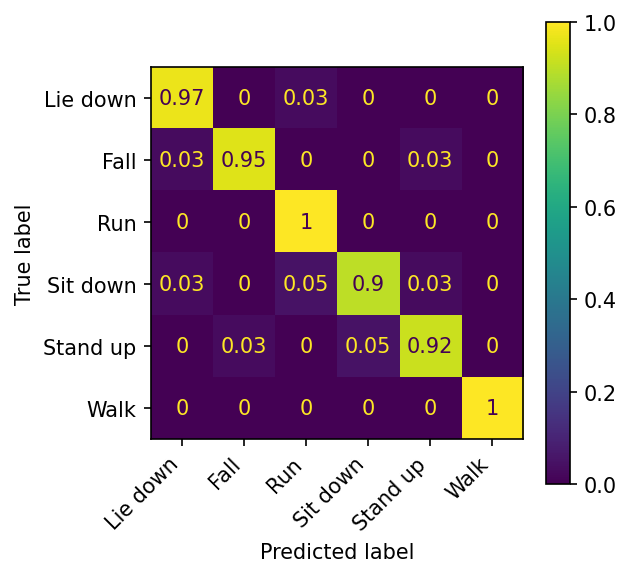

In [17]:
nLayer = 1
dSampTarget = 2
biDirTarget = True
nHiddenTarget = 200
dataWinTarget = True

dSampSurro = 10
biDirSurro = True
nHiddenSurro = 200
dataWinSurro = False

if biDirTarget:
    LSTMNameTarget = "BiLSTM"
else:
    LSTMNameTarget = "LSTM"
if biDirSurro:
    LSTMNameSurro = "BiLSTM"
else:
    LSTMNameSurro = "LSTM"


modelFileNameTarget = dataType + '_target_' + LSTMNameTarget +\
    '_H_' + str(nHiddenTarget) + "_dS_" + str(dSampTarget)
if dataWinTarget:
    modelFileNameTarget = modelFileNameTarget + "_win"

modelFileNameSurro = dataType + '_surro_' + LSTMNameSurro +\
    '_H_' + str(nHiddenSurro) + "_dS_" + str(dSampSurro)
if dataWinSurro:
    modelFileNameSurro = modelFileNameSurro + "_win"

HARNetTargetSavePath = './savedModels/selected/' + modelFileNameTarget + ".cpkt"
HARNetSurroSavePath = './savedModels/selected/' + modelFileNameSurro + ".cpkt"

print('Target:', modelFileNameTarget)
print('Surro:', modelFileNameSurro)
if dataWinTarget:
    HARNetTarget = LSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirTarget,\
                    hidden_size=nHiddenTarget,\
                    num_layers=1,\
                    seq_length=seqLen,\
                    device=device)
else:
    HARNetTarget = VariableLSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirSurro,\
                    hidden_size=nHiddenSurro,\
                    num_layers=1,\
                    device=device)
HARNetSurro = VariableLSTMNet(nClasses=len(activities),\
                input_size=nSubC*nRX,\
                bidirectional=biDirSurro,\
                hidden_size=nHiddenSurro,\
                num_layers=1,\
                device=device)

HARNetTarget.load_state_dict(torch.load(HARNetTargetSavePath))
HARNetTarget.to(device)
HARNetTarget.eval()

HARNetSurro.load_state_dict(torch.load(HARNetSurroSavePath))
HARNetSurro.to(device)
HARNetSurro.eval()

noiseAmpRatio = .00001
pred, target = getPreds(tsLoader, HARNetTarget, HARNetSurro, dSampTarget, dSampSurro,\
                variableLen, noiseAmpRatio=noiseAmpRatio, slideLen=slideLen,\
                seqLen=seqLen, noiseType='random', trLoader=trLoader)
cm = confusion_matrix(target,pred,normalize ='true')
for i in range(len(activities)):
    for j in range(len(activities)):
        cm[i, j] = round(cm[i, j], 2)

if dataType == 'JAR':
    activityLabel = ['Sit still', 'Fall down', 'Lie down', 'Stand still', 'Walk', 'Turn', 'Stand', 'Sit']

elif dataType == 'TAR':
    activityLabel = ['Lie down', 'Fall', 'Run', 'Sit down', 'Stand up', 'Walk']
    # activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

ax.set_xticklabels(activityLabel, rotation=45, ha='right')
ax.set_yticklabels(activityLabel)

## Test with white-box/black-box/Universal FGM

In [8]:
# noiseAmpRatioList = [0]
noiseAmpRatioList = [1e-6, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]

for noiseAmpRatio in noiseAmpRatioList: 
    accTest = getAcc(tsLoader,\
                    HARNetTarget,\
                    HARNetSurro,\
                    dSampTarget,\
                    dSampSurro,\
                    variableLen=variableLen,\
                    noiseAmpRatio=noiseAmpRatio,\
                    noiseType='random')
    # accTest = getAcc(tsLoader, padLen, HARNet, variableLen=True)
    print('NoiseAmpRatio: {0}, Test Acc.: {1:.1f}%'.format(noiseAmpRatio, 100*accTest))

NoiseAmpRatio: 1e-06, Test Acc.: 93.3%
NoiseAmpRatio: 0.001, Test Acc.: 93.3%
NoiseAmpRatio: 0.002, Test Acc.: 93.3%
NoiseAmpRatio: 0.005, Test Acc.: 93.3%
NoiseAmpRatio: 0.01, Test Acc.: 93.3%
NoiseAmpRatio: 0.02, Test Acc.: 92.5%
NoiseAmpRatio: 0.05, Test Acc.: 93.3%
NoiseAmpRatio: 0.1, Test Acc.: 93.8%
NoiseAmpRatio: 0.2, Test Acc.: 93.8%
NoiseAmpRatio: 0.5, Test Acc.: 92.1%
NoiseAmpRatio: 1, Test Acc.: 77.9%
NoiseAmpRatio: 2, Test Acc.: 35.4%
NoiseAmpRatio: 5, Test Acc.: 17.1%
NoiseAmpRatio: 10, Test Acc.: 16.2%
